# HHL algorithm for solving linear equations
In the following notebook, we are going to let a real quantum device solve a linear system $A\vec x = \vec b$ .
We will use a quantum algorithm that was proposed by Aram Harrow, Avinatan Hassidim, and Seth Lloyd in 2008.
Very simplified, one can distinguish 4 main steps that need to be performed on our quantum device:
1. Express the solution vector $\vec b$ as a quantum state $|b\rangle$ on a register
2. Use Quantum Phase Estimation (QPE) to decompose $|b\rangle$ into eigenvectors of A and obtain A's eigenvalues
3. Invert the (in the eigenvector base, diagonal) matrix A to prepare the state $A^{-1}|b\rangle$ = $|x\rangle$
4. Apply a linear operator M to $|x\rangle$ to obtain information on the solution vector $\vec x$

Be reminded that in the general case, the entries of $\vec x$ can not be efficiently read out because we would need to know all coefficients describing the quantum state.
In the following example, we ignore this constraint and show for our small linear system as a proof of principle that $\vec x$ is calculated correctly.


As usual, lets get set up.
We import the classes and functions from qiskit as well as some custom functions that will help us adding special gates to the circuit

In [27]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
%autoreload 2

In [29]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, register,get_backend,available_backends,least_busy
from qiskit.tools.qi.pauli import Pauli
from qiskit_aqua import Operator, QuantumAlgorithm, AlgorithmError
from qiskit_aqua import get_initial_state_instance, get_iqft_instance
from fix_rotation import add_eigenvalue_inversion, add_measurement_gates, generate_matrix, print_linsystem,add_eigenvalue_inversion_q

from qiskit.tools.visualization._circuit_visualization import matplotlib_circuit_drawer

import numpy as np


from qpe import QPE


In [30]:
try:
    import Qconfig
    qx_config = {
       "APItoken": Qconfig.APItoken,
       "url": Qconfig.config['url']}
except Exception as e:
    print(e)
    qx_config = {
       "APItoken":"6481b0a273869ee834cbd427bbd4480bea29047f6828d578850275ddf012c627b8de551f7297713eb4175791b7c024d11e58e80c47f243b734c4ce427110c3e3",
       "url":"https://quantumexperience.ng.bluemix.net/api"}
    register(qx_config['APItoken'], qx_config['url'])

No module named 'Qconfig'


In [31]:
N = 2
N_ev = 2
N_sv = int(np.log2(N))
measure = True
backend = "local_qasm_simulator"
print(N,N_ev,N_sv)

2 2 1


## State preparation and QPE

The HHL algorithm starts off with the preparation of $\vec b$ in one register followed by the Quantum Phase Estimation that decomposes $|b\rangle$ into eigenvectors of $A$ and prepares the eigenvalues in a second register.

In [41]:
matrix =generate_matrix()#np.array([[2, -1 ],[-1, 2]])#generate_matrix()
w, v = np.linalg.eigh(matrix) 

print(matrix)
print("Eigenvalues:", w)

invec =  [1,0]#1/np.sqrt(2)*np.array([1,1])#[1,0]#[1,0]#

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae':2,
            'num_time_slices': 1,
            'expansion_mode': 'trotter',
            'expansion_order': 1,
            'hermitian_matrix': True,
            'negative_evals': False,
            'backend' : backend,#"local_qasm_simulator",
            'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec#[1/2**0.5,1/2**0.5]
    }
}

[[ 2 -1]
 [-1  2]]
Eigenvalues: [1. 3.]


In [53]:
qpe = QPE()
qpe.init_params(params, matrix)

qc = qpe._setup_qpe(measure=False)
c1 = ClassicalRegister(2, name='controlbit')
c2 = ClassicalRegister(N_sv, name='solution_vector')
c = ClassicalRegister(2, name='c')
qc.add(c)
qc.add(c1)
qc.add(c2)
#matplotlib_circuit_drawer(qc)

QPE circuit qasm length is roughly 29.


Take a look at above circuit. The gate(s) in front of the first U gate that is applied to quibit 0 of the topmost register, prepare us the initial state vector $\vec b$ .
Following, so called Hamiltonian simulation techniques are used to apply the operator $\exp{i At}$ to our register containing the state vector. These


## Inversion and rotation
The last step before we can perform our measurement is to invert $A$. We have $\vec b$ represented in the basis of eigenvectors of A so simply using the inverse eigenvalues gives us $A^{-1}$ . 
Given that this transformation of the eigenvalues from $\lambda$ to $\lambda^{-1}$ is not unitary, we have a probability of failing this step. Unfortunately we do not have direct access to the state of the qubits and we can not "measure" if the inversion suceeded.
Instead we will perform a rotation of $\arcsin{\frac{C}{\lambda}}$ on a "control" qubit. One can show that the state of the control qubit changes from $|0\rangle$ to $\sqrt{1-\frac{C^2}{\lambda_{j}^2}}|0\rangle+\frac{C}{\lambda_j}|1\rangle$ (corresponding to a rotation around the y axis of the Bloch sphere), hence a measurement result of 1 in the control qubit assures us, that the inversion has suceeded.

In [54]:

add_eigenvalue_inversion_q(qc)
#matplotlib_circuit_drawer(qc)

In [55]:
qc += qpe._construct_inverse()
#matplotlib_circuit_drawer(qc)

Now we add some measurements to our circuit. The qubit storing the solution vector and the control qubit are read out into classical registers

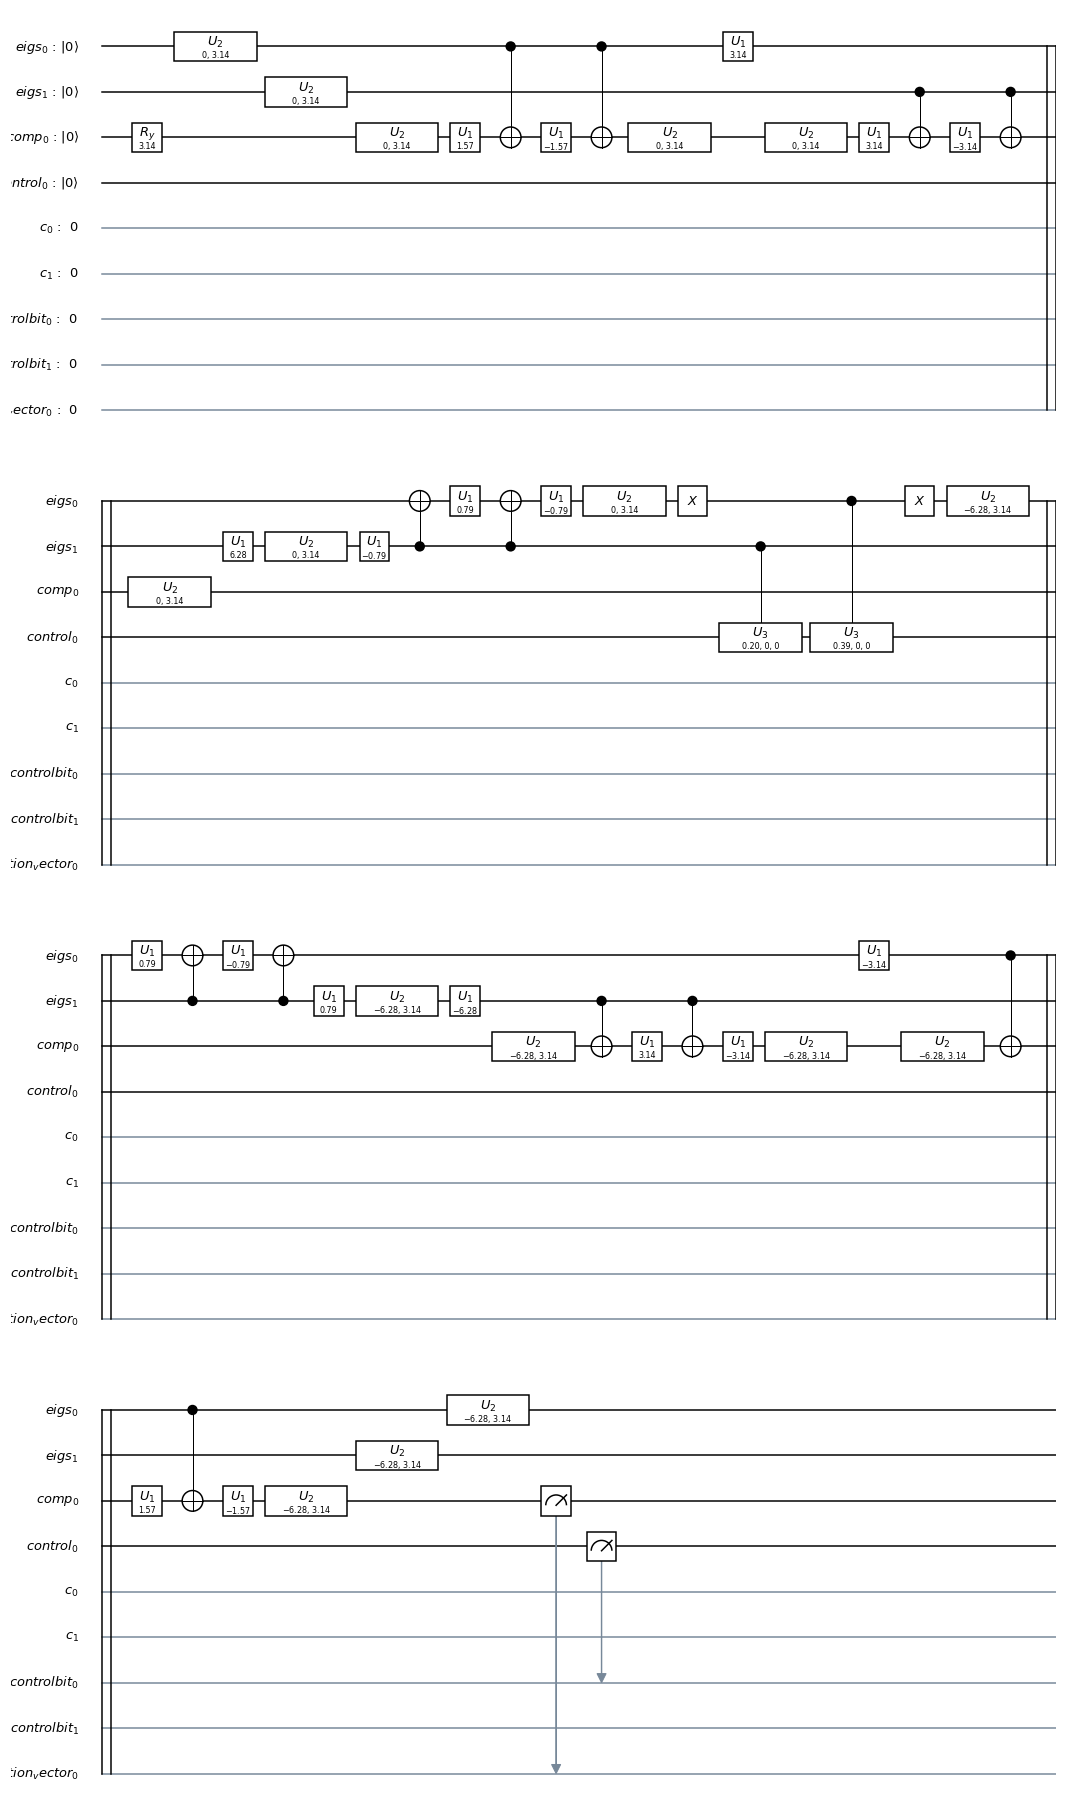

In [56]:
add_measurement_gates(qc)
matplotlib_circuit_drawer(qc)

We are ready to run our HHL program! 

In [57]:
result = execute(qc, backend=backend, shots=3024).result()
print(result.get_counts())

{'0 00 00': 3, '0 01 00': 23, '1 00 00': 2889, '1 01 00': 109}


In [58]:
N0 = result.get_counts(qc)['1 01 00']
N1 = result.get_counts(qc)['0 01 00']
print(N1/N0)

0.21100917431192662


The ratio of N0 and N1, i.e. the  relative probability of measuring 1, 0 respectively in the solution vector qubit, gives us the relative scale of the two entries in the vector.

Lets repeat our program several times to obtain better statistics... 

In [67]:
matrix =generate_matrix()
w, v = np.linalg.eigh(matrix) 

print(matrix)
print("Eigenvalues:", w)

invec =  1/np.sqrt(2)*np.array([1,1])#[1,0]#1/np.sqrt(2)*np.array([1,1])#[1,0]#[1,0]#

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae':2,
            'num_time_slices': 1,
            'expansion_mode': 'trotter',
            'expansion_order': 1,
            'hermitian_matrix': True,
            'negative_evals': False,
            'backend' : backend,#"local_qasm_simulator",
            'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec#[1/2**0.5,1/2**0.5]
    }
}

[[ 2 -1]
 [-1  2]]
Eigenvalues: [1. 3.]


In [68]:
from fix_rotation import add_eigenvalue_inversion, add_measurement_gates, generate_matrix, print_linsystem, add_eigenvalue_inversion_q
N0 = 0
N1 = 0
for i in range(10):
    qpe = QPE()


    qpe.init_params(params, matrix)

    qc = qpe._setup_qpe(measure=False)
    c1 = ClassicalRegister(1, name='controlbit')
    c2 = ClassicalRegister(N_sv, name='solution_vector')
    c = ClassicalRegister(2, name='c')
    qc.add(c)
    qc.add(c1)
    qc.add(c2)
    add_eigenvalue_inversion_q(qc)
    qc += qpe._construct_inverse()
    add_measurement_gates(qc)
    result = execute(qc, backend=backend, shots=8100).result()
    print(result.get_counts(qc))
    try:
        N0 = N0 + result.get_counts(qc)['1 1 00']
    except:
        pass
    try:
        N1 = N1 + result.get_counts(qc)['0 1 00']
    except:
        pass
    print(result)
    

QPE circuit qasm length is roughly 29.
{'0 0 00': 3717, '0 1 00': 316, '1 0 00': 3735, '1 1 00': 332}
COMPLETED
QPE circuit qasm length is roughly 29.
{'0 0 00': 3694, '0 1 00': 332, '1 0 00': 3725, '1 1 00': 349}
COMPLETED
QPE circuit qasm length is roughly 29.
{'0 0 00': 3767, '0 1 00': 343, '1 0 00': 3656, '1 1 00': 334}
COMPLETED
QPE circuit qasm length is roughly 29.
{'0 0 00': 3771, '0 1 00': 325, '1 0 00': 3687, '1 1 00': 317}
COMPLETED
QPE circuit qasm length is roughly 29.
{'0 0 00': 3706, '0 1 00': 342, '1 0 00': 3678, '1 1 00': 374}
COMPLETED
QPE circuit qasm length is roughly 29.
{'0 0 00': 3786, '0 1 00': 330, '1 0 00': 3665, '1 1 00': 319}
COMPLETED
QPE circuit qasm length is roughly 29.
{'0 0 00': 3755, '0 1 00': 336, '1 0 00': 3655, '1 1 00': 354}
COMPLETED
QPE circuit qasm length is roughly 29.
{'0 0 00': 3706, '0 1 00': 331, '1 0 00': 3703, '1 1 00': 360}
COMPLETED
QPE circuit qasm length is roughly 29.
{'0 0 00': 3742, '0 1 00': 358, '1 0 00': 3626, '1 1 00': 374}
CO

In [69]:
print_linsystem(matrix,np.sqrt(N1/N0),invec)

## $\begin{pmatrix}2&-1\\-1&2\end{pmatrix}$$\begin{pmatrix}a_0\\1.0a_0\end{pmatrix}$$= \begin{pmatrix}0.7071067811865475\\0.7071067811865475\end{pmatrix}$

## $a_0 = 0.7071067811865475$
 ## $a_0 = 0.7071067811865475$

## Equation 0 gave a result of $\begin{pmatrix}0.7071067811865475\\0.714850966818892\end{pmatrix}$

## Equation 1 gave a result of $\begin{pmatrix}0.7071067811865475\\0.714850966818892\end{pmatrix}$

## Correct $\begin{pmatrix}0.7071067811865475\\0.7071067811865475\end{pmatrix}$

In [16]:
N1/N0

0.25245258338783516

In [17]:
matrix = generate_matrix()
invec =  [1,0]#1/np.sqrt(2)*np.array([1,1])#[1,0]#[1,0]#

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae':2,
            'num_time_slices': 1,
            'expansion_mode': 'trotter',
            'expansion_order': 1,
            'hermitian_matrix': True,
            'negative_evals': False,
            'backend' : backend,#"local_qasm_simulator",
            'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec#[1/2**0.5,1/2**0.5]
    }
}

qpe = QPE()


qpe.init_params(params, matrix)

qpe._compute_eigenvalue()
#qpe._evo_time

QPE circuit qasm length is roughly 33.
[4017, '11', '11']
[4007, '10', '10']


{'measurements': [[0.5006231306081754, '11', 3.0],
  [0.4993768693918245, '10', 1.0]],
 'evo_time': 1.5707963267948966}

## Real device
Now let's execute our quantum program on an IBM Q System. We are using only 4 qubits, so both the 5 qubit and the 16 qubit computers can be utilized.

In [24]:
matrix =generate_matrix()#np.array([[2, -1 ],[-1, 2]])#generate_matrix()
w, v = np.linalg.eigh(matrix) 
backend = least_busy(available_backends({'local': False, 'simulator': False}))#
print(matrix)
print("Eigenvalues:", w)

invec =  [0,1]#1/np.sqrt(2)*np.array([1,1])#[1,0]#[1,0]#

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae':2,
            'num_time_slices': 1,
            'expansion_mode': 'trotter',
            'expansion_order': 1,
            'hermitian_matrix': True,
            'negative_evals': False,
            'backend' : backend,
            'evo_time': 2*np.pi/4,
            
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec
    }
}
print("Selected backend:",backend)

[[ 2 -1]
 [-1  2]]
Eigenvalues: [1. 3.]
Selected backend: ibmqx5


In [25]:
from fix_rotation import add_eigenvalue_inversion, add_measurement_gates, generate_matrix, print_linsystem, add_eigenvalue_inversion_q
N0_realdev = 0
N1_realdev = 0
for i in range(3):
    qpe = QPE()


    qpe.init_params(params, matrix)

    qc = qpe._setup_qpe(measure=False)
    c1 = ClassicalRegister(1, name='controlbit')
    c2 = ClassicalRegister(N_sv, name='solution_vector')
    c = ClassicalRegister(2, name='c')
    qc.add(c)
    qc.add(c1)
    qc.add(c2)
    add_eigenvalue_inversion_q(qc)
    qc += qpe._construct_inverse()
    add_measurement_gates(qc)
    result = execute(qc, backend=backend, shots=3000).result()
    print(result.get_counts(qc))
    try:
        N0_realdev = N0_realdev + result.get_counts(qc)['1 1 00']
    except:
        pass
    try:
        N1_realdev = N1_realdev + result.get_counts(qc)['0 1 00']
    except:
        pass
    print(result)
    

QPE circuit qasm length is roughly 30.
{'0 0 00': 338, '1 0 00': 218, '0 1 00': 347, '1 1 00': 276, '0 0 10': 107, '1 0 10': 98, '0 1 10': 160, '1 1 10': 122, '0 0 01': 210, '1 0 01': 203, '0 1 01': 237, '1 1 01': 237, '0 0 11': 96, '1 0 11': 111, '0 1 11': 126, '1 1 11': 114}
COMPLETED
QPE circuit qasm length is roughly 30.
{'0 0 00': 185, '0 0 01': 171, '1 0 00': 224, '1 0 01': 189, '0 0 10': 111, '0 0 11': 100, '1 0 10': 131, '1 0 11': 128, '0 1 00': 341, '0 1 01': 266, '1 1 00': 307, '1 1 01': 246, '0 1 10': 180, '0 1 11': 131, '1 1 10': 156, '1 1 11': 134}
COMPLETED
QPE circuit qasm length is roughly 30.
{'0 0 00': 406, '0 0 10': 223, '0 0 01': 539, '0 0 11': 238, '1 0 00': 266, '1 0 10': 140, '1 0 01': 277, '1 0 11': 181, '0 1 00': 133, '0 1 10': 75, '0 1 01': 158, '0 1 11': 117, '1 1 00': 77, '1 1 10': 43, '1 1 01': 71, '1 1 11': 56}
COMPLETED


In [26]:
print_linsystem(matrix,np.sqrt(N1_realdev/N0_realdev),invec)

## $\begin{pmatrix}2&-1\\-1&2\end{pmatrix}$$\begin{pmatrix}a_0\\0.9a_0\end{pmatrix}$$= \begin{pmatrix}0\\1\end{pmatrix}$

## $a_0 = 0.0$
 ## $a_0 = 1.25$

## Equation 0 gave a result of $\begin{pmatrix}0.0\\0.0\end{pmatrix}$

## Equation 1 gave a result of $\begin{pmatrix}1.25\\1.120754270115866\end{pmatrix}$

## Correct $\begin{pmatrix}0.3333333333333333\\0.6666666666666666\end{pmatrix}$